In [136]:
using LinearAlgebra
using Plots
using Statistics
using BenchmarkTools

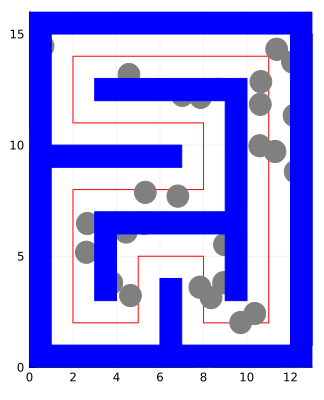

In [144]:
# Make test environment

# Waypoints for path following
path = zeros(Float64, 13, 2)
path[1,:] = [2,2]
path[2,:] = [2,8]
path[3,:] = [8,8]
path[4,:] = [8,11]
path[5,:] = [2,11]
path[6,:] = [2, 14]
path[7,:] = [11, 14]
path[8,:] = [11, 2]
path[9,:] = [8, 2]
path[10,:] = [8, 5]
path[11,:] = [5, 5]
path[12,:] = [5, 2]
path[13,:] = [2,2]

# make more dense
d_path = 0.05
dense_path = zeros(Float64, 0, 2)
for i in 1:size(path)[1]-1
    vect = path[i+1,:] - path[i,:]
    norm = LinearAlgebra.norm(vect)
    unit_vect = vect / norm
    for j in 0:d_path:norm
        point = path[i,:] + j * unit_vect
        dense_path = vcat(dense_path, point')
    end
end

path = dense_path

barriers = []

barrier1 = [0 0; 13 1]
barrier2 = [0 1; 1 15]
barrier3 = [0 15; 13 16]
barrier4 = [12 1; 13 15]
barrier5 = [3 3; 4 7]
barrier6 = [4 6; 9 7]
barrier7 = [9 3; 10 13]
barrier8 = [3 12; 9 13]
barrier9 = [1 9; 7 10]
barrier10 = [6 1; 7 4]

push!(barriers, barrier1)
push!(barriers, barrier2)
push!(barriers, barrier3)
push!(barriers, barrier4)
push!(barriers, barrier5)
push!(barriers, barrier6)
push!(barriers, barrier7)
push!(barriers, barrier8)
push!(barriers, barrier9)
push!(barriers, barrier10)

function make_shape(barrier)
    return Shape([(barrier[1,1], barrier[1,2]), (barrier[1,1], barrier[2,2]), (barrier[2,1], barrier[2,2]), (barrier[2,1], barrier[1,2]), ])
end

num_obstacles = 30
obstacle_radius = 0.5
ang = range(0, 2π, length = 60)
obstacles = []
# push!(obstacles, [11, 5])
for i in 1:num_obstacles
    obstacle = [rand()*13, rand()*16]
    push!(obstacles, obstacle)
end

p = plot(legend = false, size=[1300/4, 1600/4], xlims=(0,13), ylims=(0,16))
function plot_env(p)
    plot!(p, path[:,1], path[:,2], linecolor = RGB(1,0,0))
    for obstacle in obstacles
        plot!(p, Shape(obstacle_radius*sin.(ang).+obstacle[1], obstacle_radius*cos.(ang).+obstacle[2]), color=RGB(0.5, 0.5, 0.5), linecolor = RGB(0.5, 0.5, 0.5))
    end
    plot!(p, make_shape(barrier1), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier2), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier3), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier4), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier5), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier6), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier7), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier8), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier9), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
    plot!(p, make_shape(barrier10), color=RGB(0.0, 0.0, 1.0), linecolor = RGB(0,0,1))
end
plot_env(p)

In [138]:
include("CC-MPPI.jl")

# --------[Define Variables]-----------
x_dim = 5
u_dim = 2
N = 10
dt = 0.1
nu = 1000

# MPPI Hyperparams
lambda = 1
M = 256
mu = zeros(Float64, u_dim)

# Variance on controls
sigma_control = zeros(Float64, u_dim, u_dim)
sigma_control[1, 1] = 0.1
sigma_control[2, 2] = 0.12

# Q is state cost matrix
# R is control cost matrix
# Q = Matrix{Float64}(0.01I, x_dim, x_dim)   # so far this is the best!
# Q[1,1] = 0
# Q[2,2] = 0
Q = zeros(Float64, x_dim, x_dim)
R = Matrix{Float64}(0.01I, u_dim, u_dim)

# Final State Covariance
sigma_xf = Matrix{Float64}(100I, x_dim, x_dim)
sigma_xf[1,1] = 0.05
sigma_xf[2,2] = 0.05

En = zeros(Float64, (x_dim, (N+1)*x_dim))
En[:,N*x_dim+1:(N+1)*x_dim] = Matrix{Float64}(I, x_dim, x_dim)
Q_bar = zeros(Float64, ((N+1)*x_dim, (N+1)*x_dim))
R_bar = zeros(Float64, (N*u_dim, N*u_dim))
sigma_control_bar = zeros(Float64, (N*u_dim, N*u_dim))
for k in 1:N
    Q_bar[(k-1)*x_dim + 1:k*x_dim , (k-1)*x_dim + 1:k*x_dim] = Q
    R_bar[(k-1)*u_dim + 1:k*u_dim , (k-1)*u_dim + 1:k*u_dim] = R
    sigma_control_bar[(k-1)*u_dim + 1:k*u_dim , (k-1)*u_dim + 1:k*u_dim] = sigma_control
end
Q_bar[N*x_dim + 1:(N+1)*x_dim , N*x_dim + 1:(N+1)*x_dim] = Q

# OPTIMIZATION MODEL
opt_model = Model(SCS.Optimizer)
set_silent(opt_model)
set_optimizer_attribute(opt_model, "max_iters", 1000)
@variable(opt_model, K_var[1:u_dim, 1:x_dim, 1:N])
print("done")


done

[ Info: Saved animation to /Users/kamilnocon/Documents/Classes/ROB590/ContingentMPC/Nonlinear_ver/cleanup/test.gif


Plots.AnimatedGif("/Users/kamilnocon/Documents/Classes/ROB590/ContingentMPC/Nonlinear_ver/cleanup/test.gif")
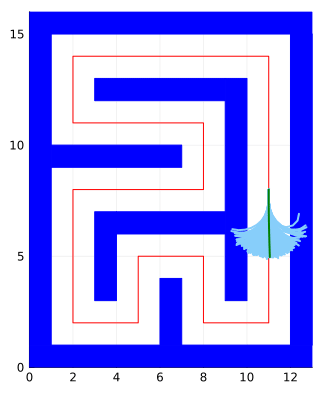

In [140]:
include("CC-MPPI.jl")
include("VehicleModels.jl")
# number of iterations to run mppi for
num_iter = 200

# set initial state 
# x0 = [8, 5, 3.14, 3, 0]
x0 = [11, 8, 4.71238898038, 3, 0]

# set initial control sequence
U = zeros(Float64, N, u_dim)

# for plotting
X_log = zeros(Float64, num_iter+1, x_dim)


X_log[1,:] = x0
anim = @animate for i in 1:num_iter
    x = X_log[i,:]
    V, X_optimal, Xm_list, Sm_list = mppi(x, U, x_dim, u_dim, N, sigma_control, mu, M, path, barriers, obstacles, false, opt_model, sigma_xf, En, sigma_control_bar, Q_bar, R_bar)
    x = BicycleModelDynamics(x, V[1,:])
    for obstacle in obstacles
        dist = sqrt((obstacle[1] - x[1])^2 + (obstacle[2] - x[2])^2) 
        if dist < obstacle_radius
            hits += 1
        end
    end
    X_log[i+1,:] = x
    U[1:N-1,:] = V[2:N,:]
    p = plot(legend = false, size=[1300/4, 1600/4], xlims=(0,13), ylims=(0,16))
    plot_env(p)
    for m in 1:M
        plot!(p, Xm_list[m,:,1], Xm_list[m,:,2], line = (2, :lightskyblue))
    end
    plot!(p, X_optimal[:,1], X_optimal[:,2], line = (2, :green))
    plot!(p, X_log[1:i,1], X_log[1:i,2], line = (5, :red))
end
gif(anim, "test.gif", fps = 10)

1[0.1862 -0.0012; -0.0012 0.0082]
2[0.1865 -0.0073; -0.0073 0.0072]
3[0.217 0.0102; 0.0102 0.0101]
4[0.1958 -0.0006; -0.0006 0.0073]
5[0.2187 -0.0015; -0.0015 0.0101]
6[0.2188 -0.0045; -0.0045 0.0102]
7[0.2312 0.0108; 0.0108 0.0096]
8[0.207 0.0059; 0.0059 0.009]
9[0.2236 -0.0006; -0.0006 0.0074]
10[0.2256 0.006; 0.006 0.01]
11[0.2828 0.0068; 0.0068 0.0133]
12[0.2602 0.0; 0.0 0.0088]
13[0.2287 0.0001; 0.0001 0.0087]
14[0.1976 -0.1148; -0.1148 0.0814]
15[0.1631 -0.1056; -0.1056 0.0832]
16[0.1196 -0.122; -0.122 0.1558]
17[0.0356 -0.0354; -0.0354 0.2075]
18[0.0371 0.0287; 0.0287 0.2049]
19[0.0916 0.0836; 0.0836 0.1883]
20[0.1532 0.0807; 0.0807 0.103]
21[0.2511 0.0461; 0.0461 0.0569]
22[0.2655 0.018; 0.018 0.0434]
23[0.2845 0.0241; 0.0241 0.0309]
24[0.2665 0.0904; 0.0904 0.0544]
25[0.254 0.1395; 0.1395 0.1004]
26[0.1012 0.1362; 0.1362 0.2095]
27[0.0235 0.0474; 0.0474 0.304]
28[0.0573 -0.0822; -0.0822 0.3]
29[0.1597 -0.1273; -0.1273 0.1753]
30[0.2267 -0.0834; -0.0834 0.076]
31[0.2616 -0.0873

[ Info: Saved animation to /Users/kamilnocon/Documents/Classes/ROB590/ContingentMPC/Nonlinear_ver/cleanup/test_CC.gif


Plots.AnimatedGif("/Users/kamilnocon/Documents/Classes/ROB590/ContingentMPC/Nonlinear_ver/cleanup/test_CC.gif")
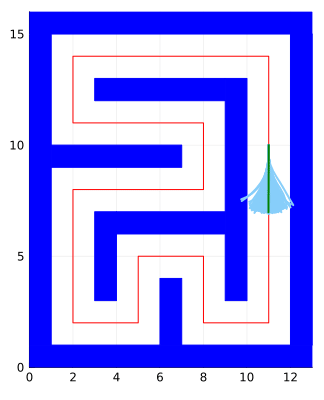

In [142]:
include("CC-MPPI.jl")
include("VehicleModels.jl")
# number of iterations to run mppi for
num_iter = 200

# set initial state 
# x0 = [8, 5, 3.14, 3, 0]
x0 = [11, 8, 4.71238898038, 3, 0]

# set initial control sequence
U = zeros(Float64, N, u_dim)

# for plotting
X_log = zeros(Float64, num_iter+1, x_dim)

X_log[1,:] = x0
anim = @animate for i in 1:num_iter
    print(i)
    flush(stdout)
    x = X_log[i,:]
    V, X_optimal, Xm_list, Sm_list = mppi(x, U, x_dim, u_dim, N, sigma_control, mu, M, path, barriers, obstacles, true, opt_model, sigma_xf, En, sigma_control_bar, Q_bar, R_bar)
    x = BicycleModelDynamics(x, V[1,:])
    X_log[i+1,:] = x
    U[1:N-1,:] = V[2:N,:]
    X_f_m = zeros(Float64, M, 2) 
    X_f_m[:,:] = Xm_list[:, N+1, 1:2]

    p = plot(legend = false, size=[1300/4, 1600/4], xlims=(0,13), ylims=(0,16))
    plot_env(p)
    for m in 1:M
        plot!(p, Xm_list[m,:,1], Xm_list[m,:,2], line = (2, :lightskyblue))
    end
    plot!(p, X_optimal[:,1], X_optimal[:,2], line = (2, :green))
    plot!(p, X_log[1:i,1], X_log[1:i,2], line = (5, :red))
    println(round.(Statistics.cov(X_f_m, dims=1), digits=4))
end
gif(anim, "test_CC.gif", fps = 10)